In [1]:
## Step 1: Set Up

# Install necessary libraries
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [2]:
## Step 2: Prepare Dataset
import zipfile

with zipfile.ZipFile('car.zip', 'r') as zip_ref:
  zip_ref.extractall('car')

In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 16 #v1=4;v2=16
NUM_CLASSES = 5
DATA_DIR = "/content/car/car-segmentation"
NUM_TRAIN_IMAGES = 200
NUM_VAL_IMAGES = 11

train_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list, target_size):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.repeat()  # 重複資料集
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)  # 套用擴增操作
    dataset = dataset.shuffle(buffer_size=len(image_list))  # 打亂資料順序
    dataset = dataset.take(target_size)  # 取出目標數量資料
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # 批次化
    return dataset

# train_dataset = data_generator(train_images, train_masks)
# val_dataset = data_generator(val_images, val_masks)
train_dataset = data_generator(train_images, train_masks, target_size=1000)  # 產生 1000 張擴增資料
val_dataset = data_generator(val_images, val_masks, target_size=50)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 1), dtype=tf.float32, name=None))>


In [11]:
## Step 3: Define UNet Model

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=(img_size, img_size, 3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(IMAGE_SIZE, NUM_CLASSES)

model.summary()  # Print model summary to check the architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 128, 128, 64)   │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 128, 128, 64)   │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 64, 64, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,059,557 (7.86 MB)

 Trainable params: 2,055,781 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 105s 964ms/step - accuracy: 0.7147 - loss: 1.6498 - val_accuracy: 0.6240 - val_loss: 3.7757
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 116s 955ms/step - accuracy: 0.8865 - loss: 0.2879 - val_accuracy: 0.7219 - val_loss: 5.5740
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 958ms/step - accuracy: 0.9228 - loss: 0.1962 - val_accuracy: 0.7141 - val_loss: 6.3496
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 965ms/step - accuracy: 0.9359 - loss: 0.1606 - val_accuracy: 0.7270 - val_loss: 4.9963
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 943ms/step - accuracy: 0.9509 - loss: 0.1198 - val_accuracy: 0.7165 - val_loss: 6.6757
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 947ms/step - accuracy: 0.9592 - loss: 0.0982 - val_accuracy: 0.7226 - val_loss: 5.6977
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 936ms/step - accuracy: 0.9659 - loss: 0.0805 - val_accuracy: 0.7187 - val_loss: 6.2722
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 960ms/step - accuracy: 0.9681 - loss: 0.0748 - val_ac

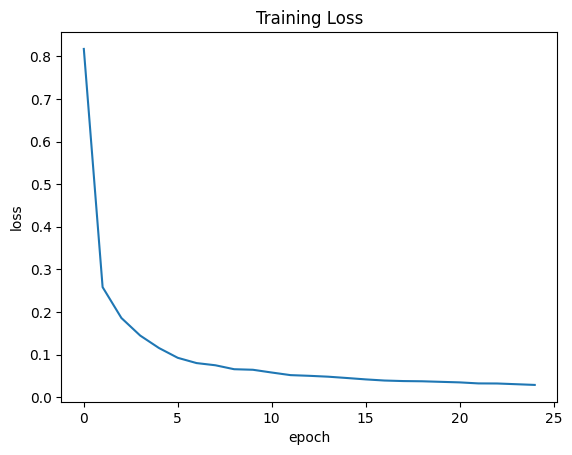

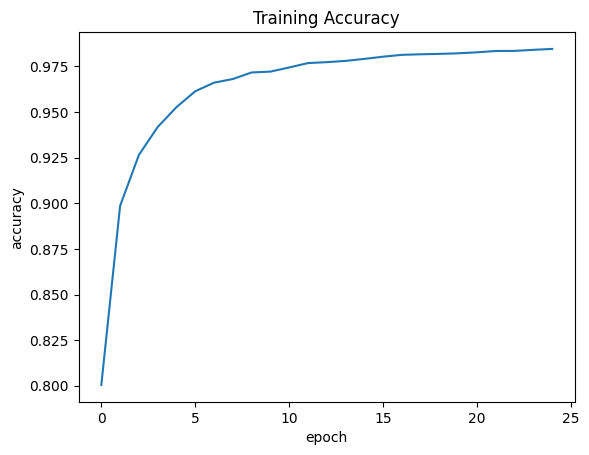

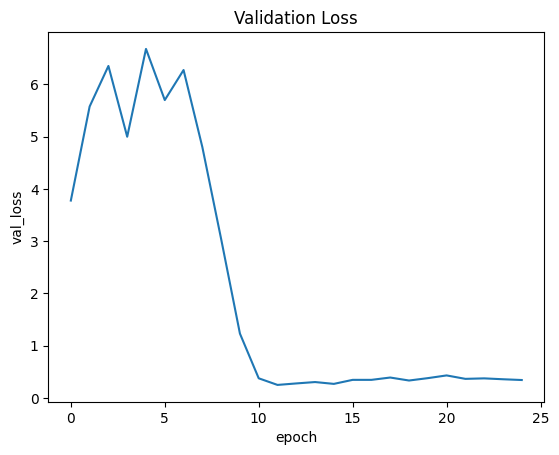

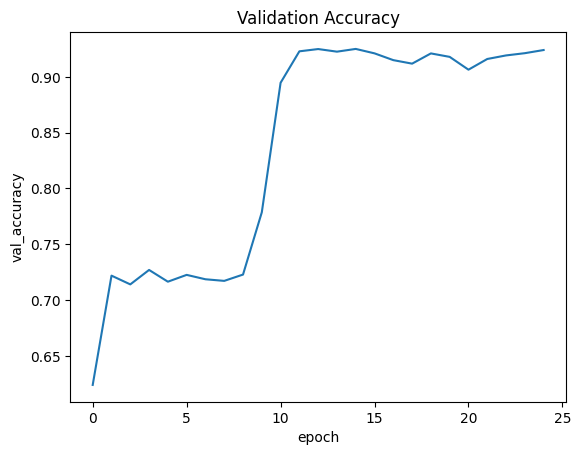

In [12]:
## Step 4: Train the Model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)  #v1=25;v2=50

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [13]:
## Step 5: Save the Model
model.save('unet_model_car_v2.keras')